### 마포구 엣지 가져오기

In [1]:
import osmnx as ox
import pandas as pd

# 1. 지역 도로망 불러오기
place_name = 'Mapo-gu, Seoul, South Korea'
print(f"'{place_name}'의 도로 네트워크 데이터를 불러옵니다...")
G = ox.graph_from_place(place_name, network_type='drive')
print("데이터를 성공적으로 불러왔습니다.\n")

# 2. 엣지 데이터 변환
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index()
unique_edges_gdf = edges_gdf.drop_duplicates(subset=['u', 'v'])

print("'oneway', 'bridge', 'tunnel' 컬럼 변환 중...")

unique_edges_gdf['oneway'] = unique_edges_gdf['oneway'].astype(int)

if 'bridge' in unique_edges_gdf.columns:
    unique_edges_gdf['bridge'] = (unique_edges_gdf['bridge'] == 'yes').astype(int)

if 'tunnel' in unique_edges_gdf.columns:
    unique_edges_gdf['tunnel'] = (unique_edges_gdf['tunnel'] == 'yes').astype(int)

# 3. 필요한 컬럼만 추출
desired_columns = ['u', 'v', 'highway', 'oneway', 'length', 'bridge', 'tunnel']
available_columns = [col for col in desired_columns if col in unique_edges_gdf.columns]
final_edges = unique_edges_gdf[available_columns]

# 4. 노드 데이터 추출 (위도, 경도 포함)
nodes_gdf = ox.graph_to_gdfs(G, nodes=True, edges=False).reset_index()
# node id, 위도(lat), 경도(lon)만 뽑기
final_nodes = nodes_gdf[['osmid', 'y', 'x']]  # y=위도(lat), x=경도(lon)

# 5. 파일 저장
edge_out = 'data/마포도로망/마포구_엣지.csv'
node_out = 'data/마포도로망/마포구_노드.csv'

final_edges.to_csv(edge_out, index=False, encoding='utf-8-sig')
final_nodes.to_csv(node_out, index=False, encoding='utf-8-sig')

print(f"\n엣지 데이터 저장 완료 → {edge_out}")
print(f"노드 데이터 저장 완료 → {node_out}")

'Mapo-gu, Seoul, South Korea'의 도로 네트워크 데이터를 불러옵니다...
데이터를 성공적으로 불러왔습니다.

'oneway', 'bridge', 'tunnel' 컬럼 변환 중...

엣지 데이터 저장 완료 → data/마포도로망/마포구_엣지.csv
노드 데이터 저장 완료 → data/마포도로망/마포구_노드.csv


C:\Users\skm\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\skm\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\skm\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

### 경사도 포함시키기

In [3]:
import pandas as pd
import geopandas as gpd
import osmnx as ox

# --- 1. 데이터 불러오기 ---
print("데이터를 불러옵니다...")
try:
    edges_df = pd.read_csv('data/마포도로망/마포구_엣지.csv')
    # 격자 포인트 데이터
    grid_points_df = pd.read_csv('data/경사도데이터/마포구_경사도.csv')
    print("✅ 데이터 로딩 성공.")
except FileNotFoundError as e:
    print(f"❌ 오류: '{e.filename}' 파일을 찾을 수 없습니다.")
    exit()

# --- 2. OSMnx에서 마포구 도로망 '노드' 정보 가져오기 ---
print("\nOSMnx에서 마포구 도로망의 '노드' 데이터를 불러옵니다...")
place_name = 'Mapo-gu, Seoul, South Korea'
G = ox.graph_from_place(place_name, network_type='drive')
nodes_gdf = ox.graph_to_gdfs(G, nodes=True, edges=False)
print("✅ 노드 데이터 준비 완료.")

# --- 3. 데이터 GeoDataFrame으로 변환 및 좌표계 통일 ---
print("\n데이터를 지도 형태로 변환하고 계산용 좌표계로 통일합니다...")
# 계산을 위해 미터 단위 좌표계(EPSG:5179)로 통일
target_crs = 'EPSG:5174'

# 격자 포인트 데이터를 GeoDataFrame으로 변환
grid_points_gdf = gpd.GeoDataFrame(
    grid_points_df,
    geometry=gpd.points_from_xy(grid_points_df.longitude, grid_points_df.latitude),
    crs='EPSG:4326' # 원본은 위경도
).to_crs(target_crs) # 계산용 좌표계로 변환

# OSMnx 노드 데이터도 계산용 좌표계로 변환
nodes_gdf_proj = nodes_gdf.to_crs(target_crs)
print("✅ 좌표계 통일 완료.")

# --- 4. 각 '노드'를 가장 가까운 '격자 포인트'에 매칭 ---
print("\n각 도로 노드를 가장 가까운 격자 포인트에 매칭합니다...")
# sjoin_nearest를 사용해 각 '노드'에 가장 가까운 '격자 포인트'를 찾아 데이터를 부여함
# 이 작업으로 각 노드가 속한 격자의 고도/경사도 정보를 얻게 됨
nodes_with_grid_stats = gpd.sjoin_nearest(nodes_gdf_proj, grid_points_gdf, how='left')

# 매칭 후 불필요한 컬럼 정리 (index_right, latitude, longitude 등)
nodes_with_grid_stats.drop(columns=['index_right', 'latitude', 'longitude'], inplace=True)
print("✅ 노드 <-> 격자 매칭 완료.")

# --- 5. 엣지 데이터에 노드별 고도/경사도 결합 ---
print("\n도로(엣지) 데이터에 노드별 경사도 정보를 결합합니다...")
# 'osmid'를 기준으로 통계치를 가져오기 위해 인덱스를 리셋
node_stats_df = nodes_with_grid_stats.reset_index().rename(columns={'index': 'osmid'})

# 시작 노드(u) 기준으로 고도/경사도를 붙임
edges_final = pd.merge(edges_df, node_stats_df[['osmid', 'height', 'slope_degree']], left_on='u', right_on='osmid', how='left')
edges_final.rename(columns={'height': 'u_height', 'slope_degree': 'u_slope'}, inplace=True)
edges_final.drop('osmid', axis=1, inplace=True)

# 도착 노드(v) 기준으로 고도/경사도를 붙임
edges_final = pd.merge(edges_final, node_stats_df[['osmid', 'height', 'slope_degree']], left_on='v', right_on='osmid', how='left')
edges_final.rename(columns={'height': 'v_height', 'slope_degree': 'v_slope'}, inplace=True)
edges_final.drop('osmid', axis=1, inplace=True)
print("✅ u, v 노드 스탯 결합 완료.")

# --- 6. 엣지의 최종 평균 고도/경사도 계산 ---
print("\n도로(엣지)의 최종 평균 고도/경사도를 계산합니다...")
edges_final['avg_height'] = edges_final[['u_height', 'v_height']].mean(axis=1)
edges_final['avg_slope'] = edges_final[['u_slope', 'v_slope']].mean(axis=1)

# 최종적으로 남은 빈 값은 0으로 채움 (격자 데이터 범위를 벗어난 노드가 있을 경우)
edges_final.fillna(0, inplace=True)
print("✅ 최종 평균값 계산 완료.")

# --- 7. 최종 결과 확인 및 저장 ---
final_df = edges_final[['u', 'v', 'highway', 'oneway', 'length', 'bridge', 'tunnel', 'avg_height', 'avg_slope']]

print("\n--- 최종 결과 (상위 10개) ---")
print(final_df.head(10).to_string())

output_filename = 'data/마포도로망/마포구_도로망_경사도.csv'
final_df.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"\n🎉 모든 작업 성공! '{output_filename}' 파일에 최종 결과가 저장되었습니다.")

데이터를 불러옵니다...
✅ 데이터 로딩 성공.

OSMnx에서 마포구 도로망의 '노드' 데이터를 불러옵니다...
✅ 노드 데이터 준비 완료.

데이터를 지도 형태로 변환하고 계산용 좌표계로 통일합니다...
✅ 좌표계 통일 완료.

각 도로 노드를 가장 가까운 격자 포인트에 매칭합니다...
✅ 노드 <-> 격자 매칭 완료.

도로(엣지) 데이터에 노드별 경사도 정보를 결합합니다...
✅ u, v 노드 스탯 결합 완료.

도로(엣지)의 최종 평균 고도/경사도를 계산합니다...
✅ 최종 평균값 계산 완료.

--- 최종 결과 (상위 10개) ---
           u           v      highway  oneway      length  bridge  tunnel  avg_height  avg_slope
0  287630237  2451940610  residential       0   55.091747       0       0       8.250   0.362278
1  287630237  2139941906  residential       0   62.145682       0       0       8.585   0.141539
2  287630237  3867926925  residential       0   47.049753       0       0       8.660   0.141539
3  355129296   355129297     tertiary       0   60.955065       0       0       8.630   1.946717
4  355129296  3494544694     tertiary       0  111.202019       0       0       8.595   0.986633
5  355129296  3494544693     tertiary       0  107.550002       0       0       8.630   1.946717
6  355129296 

### 차선수, 도로폭, 방향별 차선수 추가

In [5]:
# -*- coding: utf-8 -*-
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely.geometry import LineString
from pyproj import CRS, Transformer
import numpy as np

# ------------------------------------------------
# 경로/옵션
# ------------------------------------------------
# 1) 파일 경로 설정
road_fp  = 'data/전국_도로폭_차선수/전국_도로망_링크_좌표포함.csv'
slope_fp = 'data/마포도로망/마포구_도로망_경사도.csv'
out_fp   = 'data/마포도로망/마포도로망_차선수_도로폭.csv'

MAX_DISTANCE_M = 50     # 최근접 허용거리(미터)
CLIP_BUFFER_M  = 100    # 강남 경계 버퍼(m)

# ------------------------------------------------
# 1) 좌표계 정의 (커스텀 TM → WGS84)
# ------------------------------------------------
src_crs = CRS.from_proj4(
    "+proj=tmerc +lat_0=38 +lon_0=128 +k=0.9999 "
    "+x_0=400000 +y_0=600000 +ellps=bessel "
    "+units=m +no_defs +towgs84=-146.43,507.89,681.46"
)
dst_crs = CRS.from_epsg(4326)
transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)

# ------------------------------------------------
# 2) 전국 도로망 로드 → 위경도 변환 → GeoDataFrame
# ------------------------------------------------
print("[LOAD] nationwide road csv…")
road_df = pd.read_csv(road_fp)

print("[XFORM] TM -> WGS84 coords…")
road_df[['start_lon','start_lat']] = road_df.apply(
    lambda r: transformer.transform(r['START_X'], r['START_Y']),
    axis=1, result_type='expand'
)
road_df[['end_lon','end_lat']] = road_df.apply(
    lambda r: transformer.transform(r['END_X'], r['END_Y']),
    axis=1, result_type='expand'
)

road_df = road_df.rename(columns={
    'LANES':     'lanes',
    'WIDTH':     'width',
    'UP_LANES':  'up_lanes',
    'DOWN_LANES':'down_lanes'
})

print("[GDF] build nationwide GeoDataFrame…")
road_gdf = gpd.GeoDataFrame(
    road_df,
    geometry=road_df.apply(
        lambda r: LineString([
            (r['start_lon'], r['start_lat']),
            (r['end_lon'],   r['end_lat'])
        ]),
        axis=1
    ),
    crs='EPSG:4326'
)

# ------------------------------------------------
# 3) 마포 폴리곤 준비 (+버퍼)
# ------------------------------------------------
print("[AREA] load Gangnam polygon with buffer…")
gangnam_poly = ox.geocode_to_gdf("Mapo-gu, Seoul, South Korea")
gangnam_poly_5179 = gangnam_poly.to_crs(5179).buffer(CLIP_BUFFER_M)
gangnam_union_4326 = gangnam_poly_5179.to_crs(4326).unary_union

# road_gdf도 강남 경계(+버퍼)로 클리핑해서 연산량↓/오매칭↓
road_gdf = road_gdf[road_gdf.intersects(gangnam_union_4326)].copy()

# ------------------------------------------------
# 4) OSM 마포 도로망 → (u,v) 대표 geometry 1개로 축약
# ------------------------------------------------
print("[OSM] downloading Gangnam road graph…")
G = ox.graph_from_place("Mapo-gu, Seoul, South Korea", network_type="drive")
edges_all = ox.graph_to_gdfs(G, nodes=False).reset_index()
edges_all['geom_len'] = edges_all.geometry.length

edges_gdf = (
    edges_all.sort_values('geom_len', ascending=False)
             .drop_duplicates(subset=['u','v'], keep='first')
             [['u','v','geometry']]
             .set_crs('EPSG:4326')
)

# 마포평 그래프 노드/엣지 집합
gangnam_nodes = set(G.nodes)
uv_pairs = set(map(tuple, edges_gdf[['u','v']].itertuples(index=False, name=None)))
vu_pairs = {(v,u) for (u,v) in uv_pairs}
valid_pairs = uv_pairs | vu_pairs

# ------------------------------------------------
# 5) slope CSV 로드 → u,v 정수화(절대값 금지) → 강남 그래프 필터
# ------------------------------------------------
print("[LOAD] slope df…")
slope_df = pd.read_csv(slope_fp)

# 숫자 변환 + NaN/음수 제거 (절대값 금지)
for c in ['u','v']:
    slope_df[c] = pd.to_numeric(slope_df[c], errors='coerce')
slope_df = slope_df.dropna(subset=['u','v'])
slope_df = slope_df[(slope_df['u'] >= 0) & (slope_df['v'] >= 0)]
slope_df['u'] = slope_df['u'].astype(np.int64)
slope_df['v'] = slope_df['v'].astype(np.int64)

# 동일 (u,v) 완전중복 제거
slope_df = slope_df.drop_duplicates(subset=['u','v'], keep='first')

# 1차: 노드 기준 필터
slope_df = slope_df[slope_df['u'].isin(gangnam_nodes) & slope_df['v'].isin(gangnam_nodes)]

# 2차: 엣지 기준 필터(무방향 허용)
slope_df = slope_df[slope_df.apply(lambda r: (r['u'], r['v']) in valid_pairs, axis=1)]

print(f"[FILTER] remaining rows after node/edge filter: {len(slope_df):,}")

# ------------------------------------------------
# 6) geometry 붙이기 + (v,u) fallback → 그래도 없으면 제거
# ------------------------------------------------
print("[MERGE] attach OSM geometry by (u,v) with reverse fallback…")
slope_gdf = slope_df.merge(edges_gdf, on=['u','v'], how='left')

rev = edges_gdf.rename(columns={'u':'v','v':'u', 'geometry':'geometry_rev'})
slope_gdf = slope_gdf.merge(rev, on=['u','v'], how='left')
slope_gdf['geometry'] = slope_gdf['geometry'].fillna(slope_gdf['geometry_rev'])
slope_gdf = slope_gdf.drop(columns=['geometry_rev'])
slope_gdf = gpd.GeoDataFrame(slope_gdf, geometry='geometry', crs='EPSG:4326')

# geometry 없는 행 제거 (강남 외부로 튈 소지 제거)
before_drop = len(slope_gdf)
slope_gdf = slope_gdf[~slope_gdf['geometry'].isna()].copy()
print(f"[GEOM] dropped rows w/o geometry: {before_drop - len(slope_gdf):,}")

# 강남 폴리곤(+버퍼) 안으로 공간 클립(한 번 더 안전장치)
slope_gdf = slope_gdf[slope_gdf.intersects(gangnam_union_4326)].copy()

# ------------------------------------------------
# 7) 최근접 결합 (미터 좌표계에서 수행) → 엣지별 1세트 피처 부여
# ------------------------------------------------
print("[SJOIN] nearest join in meters…")
road_feat = road_gdf[['lanes','width','up_lanes','down_lanes','geometry']].copy()

# 투영 (EPSG:5179, m)
road_utm  = road_feat.to_crs(epsg=5179)
slope_utm = slope_gdf.to_crs(epsg=5179)

# 최근접 수행
joined = gpd.sjoin_nearest(
    slope_utm, road_utm,
    how='left', distance_col='dist_m', max_distance=MAX_DISTANCE_M
).drop(columns=['index_right'])

# 다시 WGS84로 복원
joined = joined.to_crs(epsg=4326)

# ------------------------------------------------
# 8) oneway == 1 규칙 적용 (있을 때만)
# ------------------------------------------------
print("[RULE] oneway=1 → lanes=1, up=1, down=0…")
if 'oneway' in joined.columns:
    one = (
        joined['oneway']
        .replace({True:1, False:0, 'True':1, 'False':0})
        .astype(float).fillna(0).astype(int)
    )
    m = one == 1
    for c in ['lanes','up_lanes','down_lanes']:
        if c not in joined.columns:
            joined[c] = pd.NA
    joined.loc[m, 'lanes']      = 1
    joined.loc[m, 'up_lanes']   = 1
    joined.loc[m, 'down_lanes'] = 0

# ------------------------------------------------
# 9) 결측 채움: pair 평균 → 전체 중앙값
# ------------------------------------------------
print("[FILL] ensure every edge has lanes/width/up/down…")
pair_key = pd.Series(list(zip(joined['u'], joined['v']))).apply(lambda x: tuple(sorted(x)))
joined['pair_key'] = pair_key

for c in ['lanes','width','up_lanes','down_lanes']:
    if c not in joined.columns:
        joined[c] = pd.NA

# pair 평균으로 1차 채움
for c in ['lanes','width','up_lanes','down_lanes']:
    mean_map = joined.groupby('pair_key')[c].mean()
    joined[c] = joined[c].fillna(joined['pair_key'].map(mean_map))

# 전체 중앙값으로 2차 채움
for c in ['lanes','width','up_lanes','down_lanes']:
    if joined[c].isna().any():
        med = joined[c].median()
        if c != 'width':
            joined[c] = joined[c].fillna(round(med) if pd.notna(med) else 1)
        else:
            joined[c] = joined[c].fillna(med if pd.notna(med) else 3.0)

# 타입 정돈
for c in ['lanes','up_lanes','down_lanes']:
    joined[c] = pd.to_numeric(joined[c], errors='coerce').fillna(1).round().astype(int)
joined['width'] = pd.to_numeric(joined['width'], errors='coerce').fillna(joined['width'].median())

# ------------------------------------------------
# 10) 마무리: 불필요 컬럼 제거, 저장 전 검증
# ------------------------------------------------
drop_cols = [c for c in ['geometry','dist_m','pair_key'] if c in joined.columns]
merged = joined.drop(columns=drop_cols).copy()
merged.columns = merged.columns.str.lower()

# u,v는 원본 유지(절대값 금지). 이미 int64 상태.
# 최종 검증: (u,v)가 강남 엣지 집합에 반드시 포함되어야 함
final_uv = set(map(tuple, merged[['u','v']].itertuples(index=False, name=None)))
assert final_uv <= uv_pairs, "Non-Gangnam edge found in final output!"

# ------------------------------------------------
# 11) 저장
# ------------------------------------------------
merged.to_csv(out_fp, index=False)
print(f"[DONE] '{out_fp}' 저장 완료 (rows={len(merged):,})")
miss_any = int(merged[['lanes','width','up_lanes','down_lanes']].isna().any(axis=1).sum())
print(f"[CHECK] missing after fill (should be 0): {miss_any}")


[LOAD] nationwide road csv…
[XFORM] TM -> WGS84 coords…
[GDF] build nationwide GeoDataFrame…
[AREA] load Gangnam polygon with buffer…
[OSM] downloading Gangnam road graph…


C:\Users\skm\AppData\Local\Temp\ipykernel_952\2243843055.py:73: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gangnam_union_4326 = gangnam_poly_5179.to_crs(4326).unary_union
C:\Users\skm\AppData\Local\Temp\ipykernel_952\2243843055.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges_all['geom_len'] = edges_all.geometry.length


[LOAD] slope df…
[FILTER] remaining rows after node/edge filter: 6,339
[MERGE] attach OSM geometry by (u,v) with reverse fallback…
[GEOM] dropped rows w/o geometry: 0
[SJOIN] nearest join in meters…
[RULE] oneway=1 → lanes=1, up=1, down=0…
[FILL] ensure every edge has lanes/width/up/down…
[DONE] 'data/마포도로망/마포도로망_차선수_도로폭.csv' 저장 완료 (rows=7,438)
[CHECK] missing after fill (should be 0): 0


### 마포도로망에 도로재질 넣기

In [11]:
import pandas as pd

# 1) 파일 경로 설정
final_fp    = 'data/마포도로망/마포도로망_차선수_도로폭.csv'
surface_fp  = 'data/도로재질/마포구_surface_도로정보.csv'
out_fp      = 'data/마포도로망/마포도로망_재질2.csv'

# 2) 데이터 로드
final_df   = pd.read_csv(final_fp)
surface_df = pd.read_csv(surface_fp)

# 3) u, v 기준으로 surface 정보 병합
#    surface_df 에는 최소한 ['u','v','surface'] 컬럼이 있다고 가정
merged = final_df.merge(
    surface_df[['u','v','surface']],
    on=['u','v'],
    how='left'
)
# 4) 빈 곳은 '아스팔트'로 채우기
merged['surface'] = merged['surface'].fillna('asphalt')
# 5) 결과 저장
merged.to_csv(out_fp, index=False)

print(f"완료: '{out_fp}'에 surface 컬럼이 추가되었습니다.")

완료: 'data/마포도로망/마포도로망_재질2.csv'에 surface 컬럼이 추가되었습니다.


### 중복셀 제거

In [13]:
import pandas as pd

# --- 1. 데이터 불러오기 ---
try:
    # 형이 준 '마포도로망_최종.csv' 파일을 불러올게
    file_path = 'data/마포도로망/마포도로망_재질2.csv'
    df = pd.read_csv(file_path)
    print(f"'{file_path}' 파일 로딩 성공!")
    original_count = len(df)
    print(f"처리 전 데이터 개수: {original_count}개")
except FileNotFoundError:
    print(f"❌ 오류: '{file_path}' 파일을 찾을 수 없어, 형.")
    exit()


# --- 2. 중복 제거 (핵심!) ---
# 'u'와 'v' 컬럼을 기준으로 중복된 행을 제거한다.
# subset=['u', 'v'] : 이 두 컬럼의 값이 모두 똑같을 때 중복으로 판단
# keep='first' : 중복된 것들 중 첫 번째 행만 남기고 나머지는 삭제
deduplicated_df = df.drop_duplicates(subset=['u', 'v'], keep='first')
deduplicated_count = len(deduplicated_df)
print("\n중복 데이터 제거 완료!")


# --- 3. 결과 저장 및 출력 ---
output_filename = 'data/마포도로망/마포도로망_test.csv'
deduplicated_df.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"처리 후 데이터 개수: {deduplicated_count}개")
print(f"총 {original_count - deduplicated_count}개의 중복 데이터가 제거되었습니다.")
print(f"\n🎉 성공! '{output_filename}' 파일에 중복이 제거된 결과가 저장되었습니다.")

'data/마포도로망/마포도로망_재질2.csv' 파일 로딩 성공!
처리 전 데이터 개수: 12036개

중복 데이터 제거 완료!
처리 후 데이터 개수: 6339개
총 5697개의 중복 데이터가 제거되었습니다.

🎉 성공! 'data/마포도로망/마포도로망_test.csv' 파일에 중복이 제거된 결과가 저장되었습니다.


### 마지막확인

✅ '은평도로망_최종_V3.csv' 파일 로딩 성공.
u,v에 해당하는 실제 좌표를 찾기 위해 OSMnx에서 전체 노드 정보를 가져옵니다...
✅ 전체 노드 정보 준비 완료.
형이 준 데이터를 바탕으로 지도를 재구성합니다...
✅ 지도 재구성 완료.
재구성한 지도를 화면에 표시합니다...


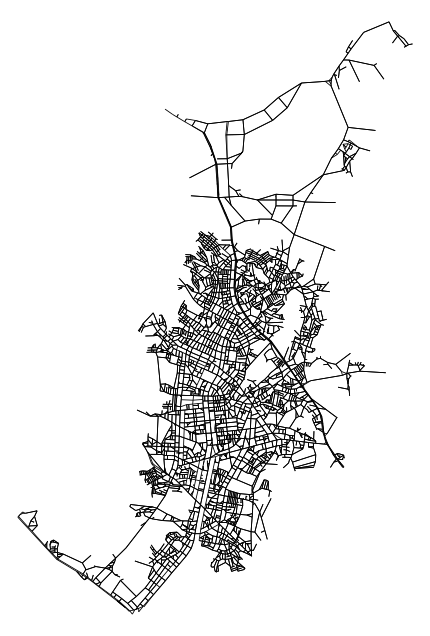


🎉 완료! 형이 준 파일의 u,v 정보로 도로망을 지도에 표시했어.


In [5]:
import pandas as pd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. 형이 준 엣지 데이터 불러오기 ---
try:
    edges_df = pd.read_csv('data/마포도로망/마포도로망_최종_V3.csv')
    print("✅ '마포도로망_최종_V3.csv' 파일 로딩 성공.")
except FileNotFoundError:
    print("❌ 오류: '마포도로망_최종_V3.csv' 파일을 찾을 수 없어, 형.")
    exit()

# --- 2. OSMnx에서 전체 노드 위치 정보 가져오기 ---
print("u,v에 해당하는 실제 좌표를 찾기 위해 OSMnx에서 전체 노드 정보를 가져옵니다...")
place_name = 'Mapo-gu, Seoul, South Korea'
G_full = ox.graph_from_place(place_name, network_type='drive')
nodes_gdf = ox.graph_to_gdfs(G_full, edges=False)
print("✅ 전체 노드 정보 준비 완료.")

# --- 3. 형의 데이터로 커스텀 그래프(Graph) 만들기 ---
print("형이 준 데이터를 바탕으로 지도를 재구성합니다...")
G_custom = nx.MultiDiGraph()

# 원본 지도의 좌표계(crs) 정보를 커스텀 지도에 복사 (에러 방지)
G_custom.graph['crs'] = G_full.graph['crs']

# 파일에 있는 모든 노드 ID 추출
node_ids = set(edges_df['u']).union(set(edges_df['v']))
# 전체 노드 정보에서 필요한 노드만 필터링
nodes_to_add = nodes_gdf[nodes_gdf.index.isin(node_ids)]

# 필터링된 노드를 커스텀 그래프에 추가
for node_id, data in nodes_to_add.iterrows():
    G_custom.add_node(node_id, **data)

# 파일에 있는 엣지를 커스텀 그래프에 추가
for _, row in edges_df.iterrows():
    G_custom.add_edge(row['u'], row['v'], **row.to_dict())
print("✅ 지도 재구성 완료.")

# --- 4. 재구성한 그래프를 지도에 그리기 ---
print("재구성한 지도를 화면에 표시합니다...")
fig, ax = ox.plot_graph(
    G_custom,
    node_size=0,
    edge_linewidth=0.6,
    edge_color='black',
    bgcolor='#FFFFFF',
    show=False,
    close=False
)

plt.show()

print("\n🎉 완료! 형이 준 파일의 u,v 정보로 도로망을 지도에 표시했어.")